# Eurostat European Big Data Hackathon 2025

<img src="img/EU-Big-Data-Hackathon-2025_horiz_0.jpg" width="500"/>


Eurostat is organizing the fifth round of the European Big Data Hackathon from 6 to 11 March 2025 (including the presentation by the winners at the NTTS) in Brussels. 

The purpose of the 2025 hackathon is to foster expertise in integrating Earth Observation data with official statistics for producing innovative ideas for statistical products and tools relevant for the EU policies. 


The European Big Data Hackathon takes place every two years and gathers teams from all over Europe to compete for the best solution to a statistical challenge. The teams develop innovative approaches, applications and data products combining official statistics and big data that can help to answer pressing EU policy and/or statistical questions.

_Source: https://cros.ec.europa.eu/2025EuropeanBigDataHackathon_

# How to download, visualise and run some basic statistics on ERA5 data

*Written by William Ray for the participants of the 5th European Big Data Hackathon 2025.*

In this notebook you are shown how to:

- Download ERA5 data from the Climate Data Store using API.
- How to visualise the downloaded data using xarray.
- Run some basic statistics such as the average temperature over a year.
- Visualise the average temperature difference between 1950 and 2023.

Before you get started you will need to create an account at the [Climate Data Store](https://cds.climate.copernicus.eu/).



In [1]:
#!pip install xarray dask cartopy cdsapi netCDF4
# Python Standard Libraries
import os
import datetime as dt

# Data Manipulation Libraries
import numpy as np
import xarray as xr

# Visualization Libraries
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Climate Data Store API for retrieving climate data
import cdsapi

## Downloading the Data

First, we'll load ERA5 data from the [Climate Data Store (CDS)](https://doi.org/10.24381/cds.f17050d7) using the `cdsapi`, including the land-sea mask. To do this, provide your CDS API key.

In [2]:
URL = "https://cds.climate.copernicus.eu/api/"
KEY = "APIKEY"  # add your key here the format should be as {uid}:{api-key}

New to CDS? Consider reading the [CDS tutorial](https://ecmwf-projects.github.io/copernicus-training-c3s/cds-tutorial.html) for a detailed guide.


In [3]:
file_name = {}  # dictionary containing [data source : file name]

# Add the data sources and file names
file_name.update({"era5": "temperature_era5.nc"})

# Create the paths to the files
path_to = {
    source: os.path.join(f"data/{source}/", file) for source, file in file_name.items()
}

# Create necessary directories if they do not exist
for path in path_to.values():
    os.makedirs(
        os.path.dirname(path), exist_ok=True
    )  # create the folder if not available

path_to

{'era5': 'data/era5/temperature_era5.nc'}

In [4]:
c = cdsapi.Client(url=URL, key=KEY)

c.retrieve(
    "reanalysis-era5-single-levels-monthly-means",
    {
        "format": "netcdf",
        "product_type": "monthly_averaged_reanalysis",
        "variable": ["2m_temperature", "land_sea_mask"],
        "year": list(range(1950, 2023)),
        "month": list(range(1, 13)),
        "time": "00:00",
        # 'grid': [0.25, 0.25],
    },
    path_to["era5"],
)

2025-02-07 14:45:32,688 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-07 14:45:32,689 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-02-07 14:45:33,127 INFO Request ID is 6d8a1fe6-e60e-4229-a97b-b53b907a78a7
2025-02-07 14:45:33,221 INFO status has been updated to accepted
2025-02-07 14:45:42,376 INFO status has been updated to running
2025-02-07 14:45:47,555 INFO status has been updated to successful


'data/era5/temperature_era5.nc'

## Opening the dataset

Now it is downloaded, we can open the dataset and inspect it using `xarray`.

In [9]:
data = xr.open_dataset("data/era5/temperature_era5.nc")
data

<xarray.Dataset> Size: 7GB
Dimensions:     (valid_time: 876, latitude: 721, longitude: 1440)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 7kB 1950-01-01 ... 2022-12-01
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver      (valid_time) <U4 14kB ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 4GB ...
    lsm         (valid_time, latitude, longitude) float32 4GB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [10]:
lat = data.latitude
lon = data.longitude
longitude = data.longitude - 180
data = data.sortby(longitude)

temp_2m = data.t2m[0, :, :]

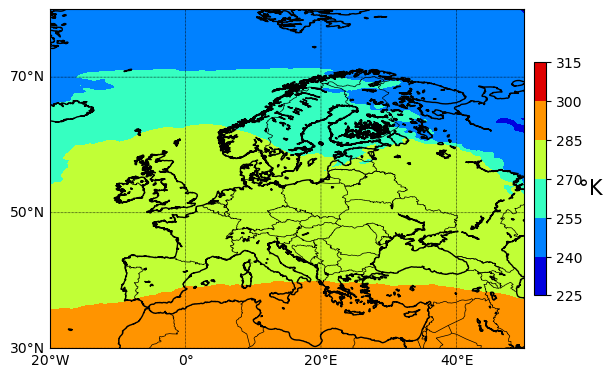

In [11]:
m = Basemap(
    projection="cyl",
    llcrnrlon=-20,
    llcrnrlat=30,
    urcrnrlon=50,
    urcrnrlat=80,
    resolution="i",
)
m.drawcoastlines(1)
m.drawcountries()

parallels = np.arange(-90, 90 + 0.25, 20)
m.drawparallels(parallels, labels=[1, 0, 0, 0], linewidth=0.5)
meridians = np.arange(-180, 180 + 0.25, 20)
m.drawmeridians(meridians, labels=[0, 0, 0, 1], linewidth=0.5)

cf = plt.contourf(longitude, lat, temp_2m, cmap="jet")
cb = plt.colorbar(cf, fraction=0.0235, pad=0.02)
cb.set_label(" \u00b0K", fontsize=15, rotation=0)

plt.show()

## Calculate the yearly average for 1950

In [12]:
start_date = "1950-01-01"
end_date = "1950-12-01"

temp_1950 = data.sel(valid_time=slice(start_date, end_date))
temp_1950

<xarray.Dataset> Size: 100MB
Dimensions:     (valid_time: 12, latitude: 721, longitude: 1440)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 96B 1950-01-01 ... 1950-12-01
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver      (valid_time) <U4 192B ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 50MB ...
    lsm         (valid_time, latitude, longitude) float32 50MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [13]:
mean_1950 = temp_1950.t2m.sum(dim="valid_time") / 12
mean_1950

<xarray.DataArray 't2m' (latitude: 721, longitude: 1440)> Size: 4MB
array([[255.91235, 255.91235, 255.91235, ..., 255.91235, 255.91235,
        255.91235],
       [255.92   , 255.92017, 255.92033, ..., 255.91936, 255.91985,
        255.92   ],
       [255.97095, 255.97112, 255.97144, ..., 255.96916, 255.96948,
        255.96997],
       ...,
       [227.4872 , 227.48817, 227.48964, ..., 227.48444, 227.4859 ,
        227.48705],
       [227.27171, 227.27284, 227.27399, ..., 227.26927, 227.27025,
        227.27106],
       [226.43236, 226.43236, 226.43236, ..., 226.43236, 226.43236,
        226.43236]], dtype=float32)
Coordinates:
    number     int64 8B ...
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8

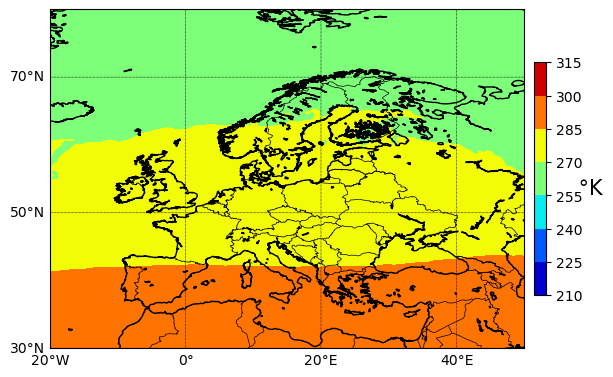

In [14]:
m = Basemap(
    projection="cyl",
    llcrnrlon=-20,
    llcrnrlat=30,
    urcrnrlon=50,
    urcrnrlat=80,
    resolution="i",
)
m.drawcoastlines(1)
m.drawcountries()

parallels = np.arange(-90, 90 + 0.25, 20)
m.drawparallels(parallels, labels=[1, 0, 0, 0], linewidth=0.5)
meridians = np.arange(-180, 180 + 0.25, 20)
m.drawmeridians(meridians, labels=[0, 0, 0, 1], linewidth=0.5)

cf = plt.contourf(longitude, lat, mean_1950, cmap="jet")
cb = plt.colorbar(cf, fraction=0.0235, pad=0.02)
cb.set_label(" \u00b0K", fontsize=15, rotation=0)

plt.show()

## Calculate the yearly average for 2020 and then visualise the difference between the average temperature in 1950 and 2020

In [15]:
start_date = "2020-01-01"
end_date = "2020-12-01"

temp_2020 = data.sel(valid_time=slice(start_date, end_date))
temp_2020

<xarray.Dataset> Size: 100MB
Dimensions:     (valid_time: 12, latitude: 721, longitude: 1440)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 96B 2020-01-01 ... 2020-12-01
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver      (valid_time) <U4 192B ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 50MB ...
    lsm         (valid_time, latitude, longitude) float32 50MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [16]:
mean_2020 = temp_2020.t2m.sum(dim="valid_time") / 12
mean_2020

<xarray.DataArray 't2m' (latitude: 721, longitude: 1440)> Size: 4MB
array([[260.71088, 260.71088, 260.71088, ..., 260.71088, 260.71088,
        260.71088],
       [260.65814, 260.65912, 260.65976, ..., 260.65652, 260.65717,
        260.65765],
       [260.65555, 260.65732, 260.65878, ..., 260.65115, 260.65292,
        260.6544 ],
       ...,
       [228.85541, 228.85655, 228.85802, ..., 228.85265, 228.85443,
        228.85509],
       [228.80707, 228.80772, 228.80902, ..., 228.80446, 228.80528,
        228.80592],
       [228.39447, 228.39447, 228.39447, ..., 228.39447, 228.39447,
        228.39447]], dtype=float32)
Coordinates:
    number     int64 8B ...
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8

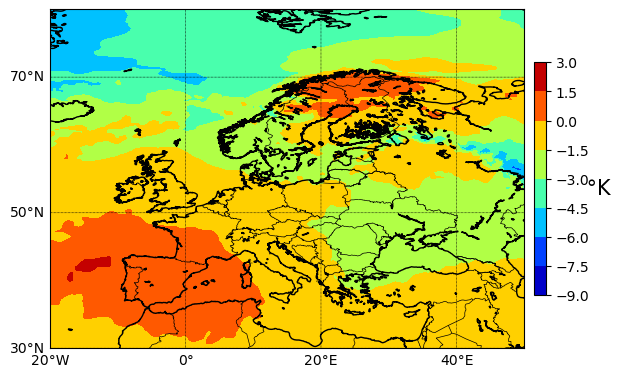

In [17]:
m = Basemap(
    projection="cyl",
    llcrnrlon=-20,
    llcrnrlat=30,
    urcrnrlon=50,
    urcrnrlat=80,
    resolution="i",
)
m.drawcoastlines(1)
m.drawcountries()

parallels = np.arange(-90, 90 + 0.25, 20)
m.drawparallels(parallels, labels=[1, 0, 0, 0], linewidth=0.5)
meridians = np.arange(-180, 180 + 0.25, 20)
m.drawmeridians(meridians, labels=[0, 0, 0, 1], linewidth=0.5)

cf = plt.contourf(longitude, lat, mean_1950 - mean_2020, cmap="jet")
cb = plt.colorbar(cf, fraction=0.0235, pad=0.02)
cb.set_label(" \u00b0K", fontsize=15, rotation=0)

plt.show()